### Load images and visualization

In [1]:
# load used packages
import os
from glob import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# check the image files in image_dataset folder
# urban 
images_urban = glob(r'image_dataset/urban/urban*')
print(images_urban[0], len(images_urban))

# rural 
images_rural = glob(r'image_dataset/rural/rural*')
print(images_rural[0], len(images_rural))

image_dataset/urban\urban0.jpeg 46
image_dataset/rural\rural0.jpeg 46


image size:  (225, 225, 3)
image size:  (225, 225, 3)


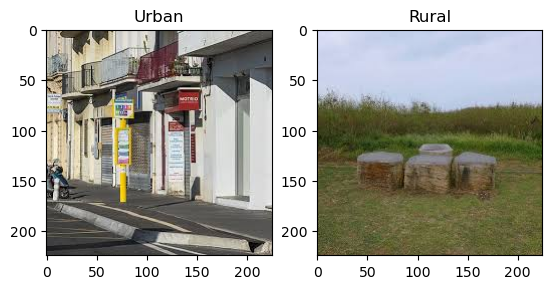

In [3]:
# using pillow to read first images from two regions and check the image size
image_urban = Image.open(images_urban[0])
print('image size: ', np.array(image_urban).shape)

image_rural = Image.open(images_rural[0])
print('image size: ', np.array(image_rural).shape)

# using matplotlib to plot images from two regions
plt.subplot(121)
plt.imshow(image_urban)
plt.title('Urban')

plt.subplot(122)
plt.imshow(image_rural)
plt.title('Rural')

plt.show()

### Model modification and weights loading

In [4]:
# using pytorch to get resnet50 model
model = models.resnet50()

In [5]:
# check the structure of resnet50 model
for layer in model.children():
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [6]:
# and found that the output layer has 1000 classes
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [7]:
# to adpat into binary classification task, and align with weights file provided, changing the output layer into 1 neuron. 
model.fc = nn.Linear(model.fc.in_features, 1)

In [8]:
# recheck if changed or not
print(model.fc)

Linear(in_features=2048, out_features=1, bias=True)


In [9]:
# load the weights files provided and found matached correctely
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [10]:
# change the mode into evalation
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Images transforamtion and model prediction

In [11]:
# add transformation to images so that they can be put into model
# in case of different image size, we resize the image into same size 256 * 256 * 3
# to align with input size of resnet50, center crop image into 224 * 224 * 3
# applied image normalization for fast model learning
# convert image into tensor for pytorch data format
transformantions = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

In [12]:
# load all images from urban folder
images_urban_list = [Image.open(p) for p in images_urban]

In [39]:
# print(len(images_urban_list), images_urban_list[0])

46 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x26864F961A0>


In [13]:
# apply transformation to each images 
images_urban_input = torch.stack([transformantions(image) for image in images_urban_list])
print(images_urban_input.shape)

torch.Size([46, 3, 224, 224])


In [14]:
# using model to make prediction on transformed images
# and apply sigmoid on logits from model's output to get prob.
with torch.no_grad():
    pre_urban = torch.sigmoid(model(images_urban_input))

In [15]:
# check the prob 
print(pre_urban)
print((pre_urban > 0.5) * 1)

tensor([[0.4328],
        [0.2952],
        [0.8124],
        [0.1954],
        [0.3390],
        [0.8609],
        [0.9921],
        [0.8901],
        [0.9176],
        [0.2156],
        [0.9416],
        [0.6686],
        [0.1282],
        [0.9581],
        [0.4701],
        [0.7989],
        [0.3433],
        [0.1599],
        [0.0168],
        [0.2793],
        [0.8544],
        [0.0783],
        [0.0368],
        [0.3922],
        [0.0621],
        [0.9792],
        [0.0229],
        [0.3067],
        [0.2989],
        [0.2112],
        [0.1388],
        [0.0398],
        [0.9779],
        [0.3173],
        [0.4337],
        [0.8655],
        [0.7992],
        [0.4205],
        [0.3865],
        [0.3742],
        [0.2187],
        [0.1476],
        [0.3807],
        [0.0344],
        [0.9770],
        [0.1059]])
tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
  

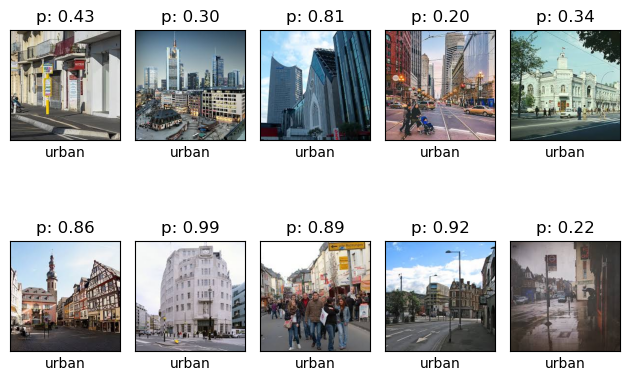

In [16]:
# plot the first 10 urban images and probs from model
fig, axs = plt.subplots(2, 5)
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(images_urban_list[i])
    axs[i].set_title(f'p: {pre_urban[i].item():.2f}')
    axs[i].set_xlabel('urban')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

In [17]:
# same operation to images from rural folder
images_rural_list = [Image.open(p) for p in images_rural]
images_rural_input = torch.stack([transformantions(image) for image in images_rural_list])

In [18]:
with torch.no_grad():
    pre_rural = torch.sigmoid(model(images_rural_input))

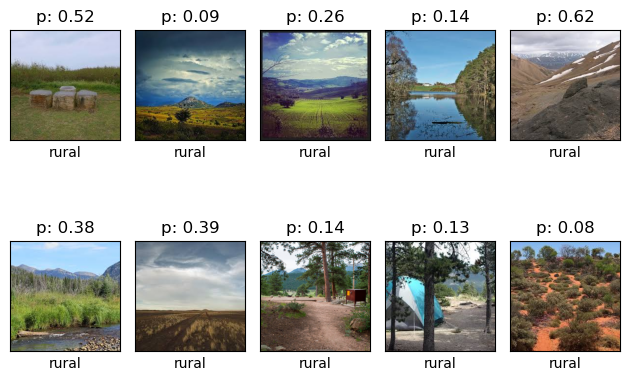

In [19]:
fig, axs = plt.subplots(2, 5)
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(images_rural_list[i])
    axs[i].set_title(f'p: {pre_rural[i].item():.2f}')
    axs[i].set_xlabel('rural')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

In [20]:
# check the probs
print(pre_rural)
print((pre_rural > 0.5) * 1)

tensor([[0.5221],
        [0.0879],
        [0.2595],
        [0.1415],
        [0.6162],
        [0.3789],
        [0.3912],
        [0.1357],
        [0.1303],
        [0.0849],
        [0.3486],
        [0.1276],
        [0.5735],
        [0.9049],
        [0.2540],
        [0.7244],
        [0.2543],
        [0.9374],
        [0.9790],
        [0.2155],
        [0.8991],
        [0.3451],
        [0.1345],
        [0.9201],
        [0.2259],
        [0.9736],
        [0.3943],
        [0.5323],
        [0.0744],
        [0.2771],
        [0.3499],
        [0.1957],
        [0.2087],
        [0.3642],
        [0.2656],
        [0.2922],
        [0.9387],
        [0.0738],
        [0.3611],
        [0.1111],
        [0.0994],
        [0.6791],
        [0.0696],
        [0.4422],
        [0.7244],
        [0.0427]])
tensor([[1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
  

### Model accuracy assessment

In [21]:
# make true labels for accuracy assessments
urban_labels = np.ones(46)
rural_labels = np.zeros(46)
true_labels = np.concatenate((urban_labels, rural_labels))
print(true_labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# convert tensor to numpy and put predictions from rural and urban together
predictions = np.concatenate((pre_urban.reshape(-1).numpy(), pre_rural.reshape(-1).numpy()))
print(predictions)

[0.43280226 0.29516917 0.8124087  0.19539358 0.33897293 0.8609043
 0.99214643 0.8900864  0.91761863 0.21564323 0.9416465  0.66856277
 0.1281995  0.95805293 0.470064   0.7988813  0.34331644 0.15994674
 0.01676454 0.27933034 0.85438097 0.07833637 0.03681291 0.39223444
 0.06210652 0.9791734  0.02285952 0.30670756 0.29892904 0.21123314
 0.13879162 0.0398211  0.9778592  0.31731257 0.43367165 0.8655031
 0.799204   0.42047527 0.38650596 0.37415    0.21866174 0.14764838
 0.38073638 0.03435046 0.97700536 0.10592401 0.5220833  0.08792832
 0.25951007 0.14148611 0.61619395 0.37885085 0.39117527 0.13568264
 0.13032287 0.08491131 0.34864917 0.12757456 0.57352495 0.9049108
 0.254025   0.7243562  0.25425082 0.93736494 0.97899026 0.21550532
 0.89911044 0.34512419 0.13452494 0.92008054 0.22590913 0.97355413
 0.39433914 0.5323463  0.07444415 0.2770767  0.34988147 0.19570196
 0.20868081 0.36423156 0.2655897  0.29219708 0.9386793  0.07382926
 0.36109337 0.11111493 0.09935784 0.6790785  0.06957396 0.4422041

In [23]:
# get pred labesl using threhold of 0.5, if prob greater than 0.5, it is from urban, otherwise it is from rural
pred_labels = (predictions > 0.5) * 1
print(pred_labels)

[0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0]


In [24]:
# calculating confusion matrixs using true labels and pred labels
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[32 14]
 [31 15]]


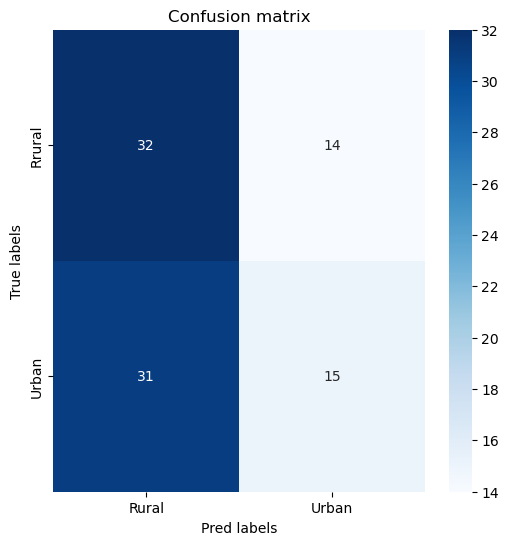

In [25]:
# using seaborn heatmap to plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rural', 'Urban'],
            yticklabels=['Rrural', 'Urban'])
plt.title('Confusion matrix')
plt.xlabel('Pred labels')
plt.ylabel('True labels')
plt.show()

In [26]:
# calculate precision, recall and overall accuracy for model predicitons 
# found that model precision is almost same for two classes, but the recall rate of urban is much lower than that of rural
# suggesting model need to be improved, and this can be done by some operations such as fine tuning with more images.
report = classification_report(true_labels, pred_labels, target_names=['Rural', 'Urban'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Rural       0.51      0.70      0.59        46
       Urban       0.52      0.33      0.40        46

    accuracy                           0.51        92
   macro avg       0.51      0.51      0.49        92
weighted avg       0.51      0.51      0.49        92

